In [1]:
import numpy as np
import matplotlib.pyplot as plt


def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']

    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z

    return np.array([dx, dy, dz])

time_steps = np.arange(0, 2000, 0.1)
params = {'σ' : 10., 'ρ' : 28., 'β' : 8/3}
xyz0 = np.array([1., 1., 1.])
lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
x, y, z = lorenz_solution[2000:].T
x = (x - min(x)) / (max(x) - min(x))
import itertools
import tqdm
from scipy.stats import mode
from sklearn.cluster import DBSCAN
from scipy import stats

In [25]:
def generate_patterns(K, L):
    patterns = np.array(list(itertools.product(np.arange(1, K+1), repeat=L)))
    return patterns

def sample_z_vectors(x, pattern):
    T = len(x)
    ind = np.array([0, *np.cumsum(pattern)])

    samples = []
    for i in range(T-ind[-1]):
        samples.append(x[ind+i])
    samples = np.array(samples)
    dbscan = DBSCAN(eps=0.01, min_samples=6)
    labels = dbscan.fit_predict(samples)
    unique_labels = set(labels)
    means = []
    for label in unique_labels:
        if label != -1:
            cluster_samples = samples[labels == label]
            mean_value = np.mean(cluster_samples, axis=0)
            means.append(mean_value)
    return np.array(means)

def sample_z_new(x, pattern):
    ind = np.array([0, *np.cumsum(pattern)])
    T = len(x) - ind[-1]
    return x[ind[:-1] + T]

def Mode(S, x_i):
    if len(S) > 0:
        mode_value, count = mode(S)
        if abs(mode_value - x_i) <= 0.025:
            return mode_value
        else:
            return np.nan
    else:
        return np.nan
    
def dbscan(S):
    if len(S) > 0:
        if len(S) > 70000:
            S = S[:70000]
        S_array = np.array(S).reshape(-1, 1)
        dbscan = DBSCAN(eps = 0.005, min_samples = 9)
        labels = dbscan.fit_predict(S_array)
        unique_labels = set(labels)
        if -1 in unique_labels:
            unique_labels.remove(-1)
        unique_labels = list(unique_labels)
        cluster_sizes = [np.sum(labels == label) for label in unique_labels]
        if len(cluster_sizes) > 0:
            largest_cluster_size = max(cluster_sizes)
            second_largest_cluster_size = sorted(cluster_sizes)[-2] if len(cluster_sizes) > 1 else 0
            if largest_cluster_size >= 3 * second_largest_cluster_size:
                return(np.mean(S_array[labels == unique_labels[np.argmax(cluster_sizes)]]))
            else:
                return np.nan
        else:
            return np.nan
    else:
        return np.nan
    
    
def self_healing(x_new, patterns, Zs, u):
    counter = 1
    while (counter > 0):
        counter = 0
        for i in range(u, len(x_new)):
            if np.isnan(x_new[i]):
                S = []
                for j, pattern in enumerate(patterns):
                    if (len(Zs[j]) > 0):
                        ind = np.array([0, *np.cumsum(pattern)])
                        if (i + ind[4] < len(x_new)):
                            z_new = x_new[ind[[1, 2, 3, 4]] + i]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [1, 2, 3, 4]] - z_new), axis=1) < 0.01][:, 0])
                        if (i + ind[4] - ind[1] < len(x_new) and i - ind[1] > -1):
                            z_new = x_new[ind[[0, 2, 3, 4]] + i - ind[1]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 2, 3, 4]] - z_new), axis=1) < 0.01][:, 1])
                        if (i + ind[4] - ind[2] < len(x_new)  and i - ind[2] > -1):
                            z_new = x_new[ind[[0, 1, 3, 4]] + i - ind[2]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 3, 4]] - z_new), axis=1) < 0.01][:, 2])
                        if (i + ind[4] - ind[3] < len(x_new)  and i - ind[3] > -1):
                            z_new = x_new[ind[[0, 1, 2, 4]] + i - ind[3]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 4]] - z_new), axis=1) < 0.01][:, 3])
                        if (i - ind[4] > -1):
                            z_new = x_new[ind[[0, 1, 2, 3]] + i - ind[4]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 3]] - z_new), axis=1) < 0.01][:, 4])
                x_new[i] = dbscan(S)
                if not np.isnan(x_new[i]):
                    counter+=1
    
def self_healing_2(x_new, x_new_0, patterns, Zs, u):
    counter = 1
    while (counter > 0):
        counter = 0
        for i in range(u, len(x_new)):
            if np.isnan(x_new[i]):
                S = []
                for j, pattern in enumerate(patterns):
                    if (len(Zs[j]) > 0):
                        ind = np.array([0, *np.cumsum(pattern)])
                        if (i + ind[4] < len(x_new)):
                            z_new = x_new[ind[[1, 2, 3, 4]] + i]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [1, 2, 3, 4]] - z_new), axis=1) < 0.01][:, 0])
                        if (i + ind[4] - ind[1] < len(x_new) and i - ind[1] > -1):
                            z_new = x_new[ind[[0, 2, 3, 4]] + i - ind[1]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 2, 3, 4]] - z_new), axis=1) < 0.01][:, 1])
                        if (i + ind[4] - ind[2] < len(x_new)  and i - ind[2] > -1):
                            z_new = x_new[ind[[0, 1, 3, 4]] + i - ind[2]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 3, 4]] - z_new), axis=1) < 0.01][:, 2])
                        if (i + ind[4] - ind[3] < len(x_new)  and i - ind[3] > -1):
                            z_new = x_new[ind[[0, 1, 2, 4]] + i - ind[3]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 4]] - z_new), axis=1) < 0.01][:, 3])
                        if (i - ind[4] > -1):
                            z_new = x_new[ind[[0, 1, 2, 3]] + i - ind[4]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 3]] - z_new), axis=1) < 0.01][:, 4])
                x_new[i] = dbscan(S)
                if not np.isnan(x_new[i]):
                    x_new_0[i] = 1
                    counter+=1
            elif x_new_0[i] == 0:
                S = []
                for j, pattern in enumerate(patterns):
                    if (len(Zs[j]) > 0):
                        ind = np.array([0, *np.cumsum(pattern)])
                        if (i + ind[4] < len(x_new)):
                            z_new = x_new[ind[[1, 2, 3, 4]] + i]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [1, 2, 3, 4]] - z_new), axis=1) < 0.01][:, 0])
                        if (i + ind[4] - ind[1] < len(x_new) and i - ind[1] > -1):
                            z_new = x_new[ind[[0, 2, 3, 4]] + i - ind[1]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 2, 3, 4]] - z_new), axis=1) < 0.01][:, 1])
                        if (i + ind[4] - ind[2] < len(x_new)  and i - ind[2] > -1):
                            z_new = x_new[ind[[0, 1, 3, 4]] + i - ind[2]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 3, 4]] - z_new), axis=1) < 0.01][:, 2])
                        if (i + ind[4] - ind[3] < len(x_new)  and i - ind[3] > -1):
                            z_new = x_new[ind[[0, 1, 2, 4]] + i - ind[3]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 4]] - z_new), axis=1) < 0.01][:, 3])
                        if (i - ind[4] > -1):
                            z_new = x_new[ind[[0, 1, 2, 3]] + i - ind[4]]
                            if (np.all(~np.isnan(z_new))):
                                S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 3]] - z_new), axis=1) < 0.01][:, 4])
                Db = dbscan(S)
                if np.isnan(Db):
                    x_new[i] = Db
                    counter+=1

def new_self_healing(x_new, patterns, Zs, u):
    counter = 1
    while (counter > 0):
        counter = 0
        for i in range(u, len(x_new)):
            if np.isnan(x_new[i]):
                S1 = []
                S2 = []
                S3 = []
                S4 = []
                S5 = []
                for j, pattern in enumerate(patterns):
                    if (len(Zs[j]) > 0):
                        ind = np.array([0, *np.cumsum(pattern)])
                        if (i + ind[4] < len(x_new)):
                            z_new = x_new[ind[[1, 2, 3, 4]] + i]
                            if (np.all(~np.isnan(z_new))):
                                S1.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [1, 2, 3, 4]] - z_new), axis=1) <= 0.01][:, 0])
                        if (i + ind[4] - ind[1] < len(x_new) and i - ind[1] > -1):
                            z_new = x_new[ind[[0, 2, 3, 4]] + i - ind[1]]
                            if (np.all(~np.isnan(z_new))):
                                S2.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 2, 3, 4]] - z_new), axis=1) <= 0.01][:, 1])
                        if (i + ind[4] - ind[2] < len(x_new)  and i - ind[2] > -1):
                            z_new = x_new[ind[[0, 1, 3, 4]] + i - ind[2]]
                            if (np.all(~np.isnan(z_new))):
                                S3.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 3, 4]] - z_new), axis=1) <= 0.01][:, 2])
                        if (i + ind[4] - ind[3] < len(x_new)  and i - ind[3] > -1):
                            z_new = x_new[ind[[0, 1, 2, 4]] + i - ind[3]]
                            if (np.all(~np.isnan(z_new))):
                                S4.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 4]] - z_new), axis=1) <= 0.01][:, 3])
                        if (i - ind[4] > -1):
                            z_new = x_new[ind[[0, 1, 2, 3]] + i - ind[4]]
                            if (np.all(~np.isnan(z_new))):
                                S5.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 3]] - z_new), axis=1) <= 0.01][:, 4])
                x1 = dbscan(S1)
                x2 = dbscan(S2)
                x3 = dbscan(S3)
                x4 = dbscan(S4)
                x5 = dbscan(S5)
                x_arr = []
                if not np.isnan(x1):
                    x_arr.append(x1)
                if not np.isnan(x2):
                    x_arr.append(x2)
                if not np.isnan(x3):
                    x_arr.append(x3)
                if not np.isnan(x4):
                    x_arr.append(x4)
                if not np.isnan(x5):
                    x_arr.append(x5)
                if len(x_arr) == 0:
                    x_new[i] = np.nan
                elif len(x_arr) == 1:
                    x_new[i] = x_arr[0]
                else:
                    flag = True
                    for j in range(len(x_arr)):
                        for u in range(len(x_arr)):
                            if (abs(x_arr[j] - x_arr[u]) > 0.01):
                                flag = False
                    if (flag):
                        x_new[i] = np.nanmean(x_arr)
                    else:
                        x_new[i] = np.nan
                if not np.isnan(x_new[i]):
                    counter+=1

def new_point(x_new, patterns, Zs):
    S = []
    ind = len(x_new)
    for j, pattern in enumerate(patterns):
        z_new = sample_z_new(x_new, pattern)
        if (len(Zs[j]) > 0 and np.all(~np.isnan(z_new))):
            S.extend(Zs[j][np.linalg.norm(abs(Zs[j][:, [0, 1, 2, 3]] - z_new), axis=1) <= 0.01][:, 4])
    return dbscan(S)

In [3]:
patterns = generate_patterns(K=10, L=4)
Zs = []
for pattern in tqdm.tqdm(patterns):
    Zs.append(sample_z_vectors(x[:10000], pattern))

100%|██████████| 10000/10000 [09:42<00:00, 17.16it/s]


In [11]:
ans=[]
err_0 = []
for u in range(10000, 15000, 100):
    x_test = x[:u].copy()
    for i in range(u, u + 500):
        x_test = np.append(x_test, new_point(x_test, patterns, Zs))
        if ((i - u + 1) % 5 == 0):
            self_healing(x_test, patterns, Zs, u)
        cnt = 0
        for j in range(i, i - 10, -1):
            if (np.isnan(x_test[j])):
                cnt += 1
        if (cnt == 10):
            break
    cnt = 0
    for i in range(u, len(x_test)):
        if (not np.isnan(x_test[i])):
            cnt = i - u + 1
            if (x[i] != 0):
                while (len(err_0) <= i - u):
                    err_0.append([])
                err_0[i - u].append(abs(x_test[i] - x[i]) / x[i])
    ans.append(cnt)
err = []
for i in range(len(err_0)):
    err.append(np.nanmean(err_0[i]))

C:\Users\Mvideo\AppData\Local\Temp\ipykernel_12512\1018082301.py:26: RuntimeWarning: Mean of empty slice
  err.append(np.nanmean(err_0[i]))


In [13]:
ans2=[]
err2_0 = []
for u in range(10000, 15000, 100):
    x_test2 = x[:u].copy()
    for i in range(u, u + 500):
        x_test2 = np.append(x_test2, new_point(x_test2, patterns, Zs))
        if ((i - u + 1) % 10 == 0):
            self_healing(x_test2, patterns, Zs, u)
        cnt = 0
        for j in range(i, i - 10, -1):
            if (np.isnan(x_test2[j])):
                cnt += 1
        if (cnt == 10):
            break
    cnt = 0
    for i in range(u, len(x_test2)):
        if (not np.isnan(x_test2[i])):
            cnt = i - u + 1
            if (x[i] != 0):
                while (len(err2_0) <= i - u):
                    err2_0.append([])
                err2_0[i - u].append(abs(x_test2[i] - x[i]) / x[i])
    ans2.append(cnt)
err2 = []
for i in range(len(err2_0)):
    err2.append(np.nanmean(err2_0[i]))

C:\Users\Mvideo\AppData\Local\Temp\ipykernel_12512\3101514615.py:26: RuntimeWarning: Mean of empty slice
  err2.append(np.nanmean(err2_0[i]))


In [14]:
ans3=[]
err3_0 = []
for u in range(10000, 15000, 100):
    x_test3 = x[:u].copy()
    for i in range(u, u + 500):
        x_test3 = np.append(x_test3, new_point(x_test3, patterns, Zs))
        if ((i - u + 1) % 15 == 0):
            self_healing(x_test3, patterns, Zs, u)
        cnt = 0
        for j in range(i, i - 10, -1):
            if (np.isnan(x_test3[j])):
                cnt += 1
        if (cnt == 10):
            break
    cnt = 0
    for i in range(u, len(x_test3)):
        if (not np.isnan(x_test3[i])):
            cnt = i - u + 1
            if (x[i] != 0):
                while (len(err3_0) <= i - u):
                    err3_0.append([])
                err3_0[i - u].append(abs(x_test3[i] - x[i]) / x[i])
    ans3.append(cnt)
err3 = []
for i in range(len(err3_0)):
    err3.append(np.nanmean(err3_0[i]))

C:\Users\Mvideo\AppData\Local\Temp\ipykernel_12512\1513766799.py:26: RuntimeWarning: Mean of empty slice
  err3.append(np.nanmean(err3_0[i]))


In [27]:
ans4=[]
err4_0 = []
for u in range(10000, 15000, 100):
    x_test4 = x[:u].copy()
    for i in range(u, u + 500):
        x_test4 = np.append(x_test4, new_point(x_test4, patterns, Zs))
        if ((i - u + 1) % 5 == 0):
            new_self_healing(x_test4, patterns, Zs, u)
        cnt = 0
        for j in range(i, i - 10, -1):
            if (np.isnan(x_test4[j])):
                cnt += 1
        if (cnt == 10):
            break
    cnt = 0
    for i in range(u, len(x_test4)):
        if (not np.isnan(x_test4[i])):
            cnt = i - u + 1
            if (x[i] != 0):
                while (len(err4_0) <= i - u):
                    err4_0.append([])
                err4_0[i - u].append(abs(x_test4[i] - x[i]) / x[i])
    ans4.append(cnt)
err4 = []
for i in range(len(err4_0)):
    err4.append(np.nanmean(err4_0[i]))

C:\Users\Mvideo\AppData\Local\Temp\ipykernel_12512\2809550301.py:26: RuntimeWarning: Mean of empty slice
  err4.append(np.nanmean(err4_0[i]))


In [28]:
ans5=[]
err5_0 = []
for u in range(10000, 15000, 100):
    x_test5 = x[:u].copy()
    for i in range(u, u + 500):
        x_test5 = np.append(x_test5, new_point(x_test5, patterns, Zs))
        if ((i - u + 1) % 10 == 0):
            new_self_healing(x_test5, patterns, Zs, u)
        cnt = 0
        for j in range(i, i - 10, -1):
            if (np.isnan(x_test5[j])):
                cnt += 1
        if (cnt == 10):
            break
    cnt = 0
    for i in range(u, len(x_test5)):
        if (not np.isnan(x_test5[i])):
            cnt = i - u + 1
            if (x[i] != 0):
                while (len(err5_0) <= i - u):
                    err5_0.append([])
                err5_0[i - u].append(abs(x_test5[i] - x[i]) / x[i])
    ans5.append(cnt)
err5 = []
for i in range(len(err5_0)):
    err5.append(np.nanmean(err5_0[i]))

C:\Users\Mvideo\AppData\Local\Temp\ipykernel_12512\2610514071.py:26: RuntimeWarning: Mean of empty slice
  err5.append(np.nanmean(err5_0[i]))


In [29]:
ans6=[]
err6_0 = []
for u in range(10000, 15000, 100):
    x_test6 = x[:u].copy()
    for i in range(u, u + 500):
        x_test6 = np.append(x_test6, new_point(x_test6, patterns, Zs))
        if ((i - u + 1) % 15 == 0):
            new_self_healing(x_test6, patterns, Zs, u)
        cnt = 0
        for j in range(i, i - 10, -1):
            if (np.isnan(x_test6[j])):
                cnt += 1
        if (cnt == 10):
            break
    cnt = 0
    for i in range(u, len(x_test6)):
        if (not np.isnan(x_test6[i])):
            cnt = i - u + 1
            if (x[i] != 0):
                while (len(err6_0) <= i - u):
                    err6_0.append([])
                err6_0[i - u].append(abs(x_test6[i] - x[i]) / x[i])
    ans6.append(cnt)
err6 = []
for i in range(len(err6_0)):
    err6.append(np.nanmean(err6_0[i]))

C:\Users\Mvideo\AppData\Local\Temp\ipykernel_12512\4122842949.py:26: RuntimeWarning: Mean of empty slice
  err6.append(np.nanmean(err6_0[i]))


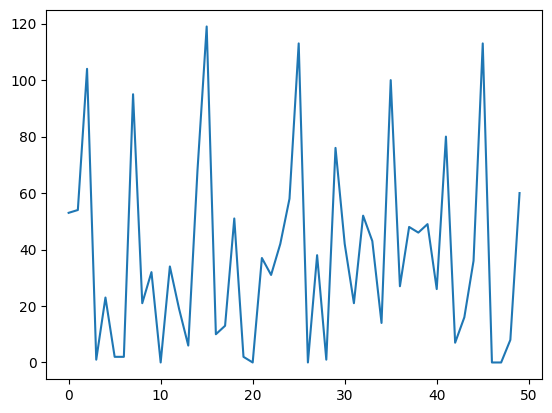

In [19]:
plt.plot(ans) # Запуск Dbscan(self_healing с шагом 5), по оси x последняя предсказанная точка, по оси y номер запуска с шагом 100

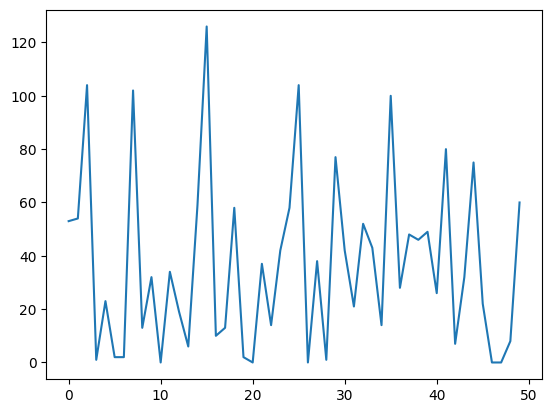

In [30]:
plt.plot(ans4) # Новый запуск Dbscan(new_self_healing с шагом 5), по оси x последняя предсказанная точка, по оси y номер запуска с шагом 100

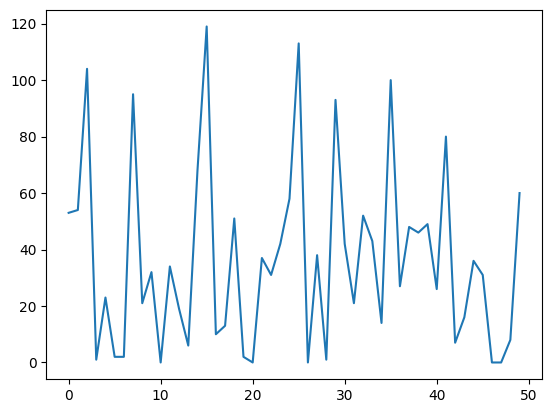

In [20]:
plt.plot(ans2) # Запуск Dbscan(self_healing с шагом 10), по оси x последняя предсказанная точка, по оси y номер запуска с шагом 100

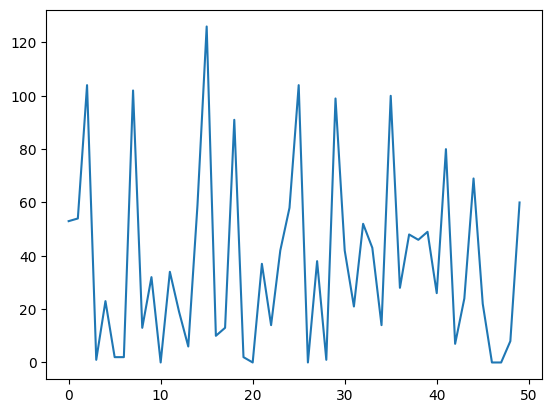

In [31]:
plt.plot(ans5) # Новый запуск Dbscan(new_self_healing с шагом 10), по оси x последняя предсказанная точка, по оси y номер запуска с шагом 100

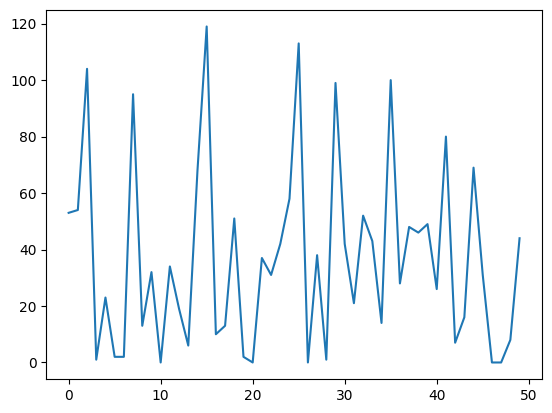

In [21]:
plt.plot(ans3) # Запуск Dbscan(self_healing с шагом 15), по оси x последняя предсказанная точка, по оси y номер запуска с шагом 100

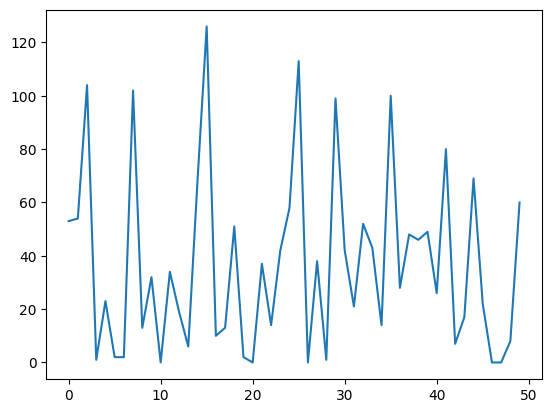

In [32]:
plt.plot(ans6) # Новый запуск Dbscan(new_self_healing с шагом 15), по оси x последняя предсказанная точка, по оси y номер запуска с шагом 100

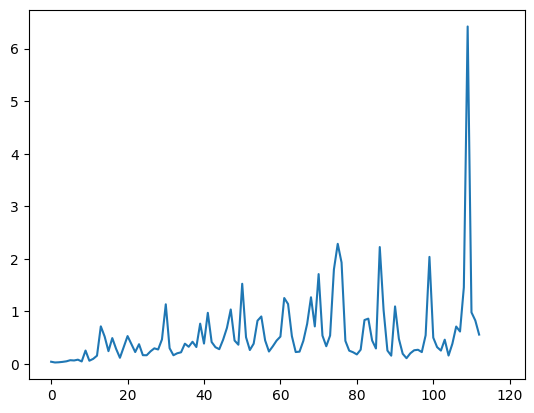

In [22]:
plt.plot(err) # Запуск Dbscan(self_healing с шагом 5), по оси x номер точки от начала запуска, по оси y средняя MAPE для этих точек

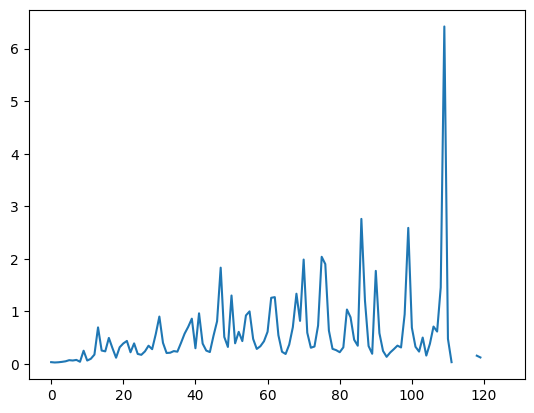

In [33]:
plt.plot(err4) # Новый запуск Dbscan(new_self_healing с шагом 5), по оси x номер точки от начала запуска, по оси y средняя MAPE для этих точек

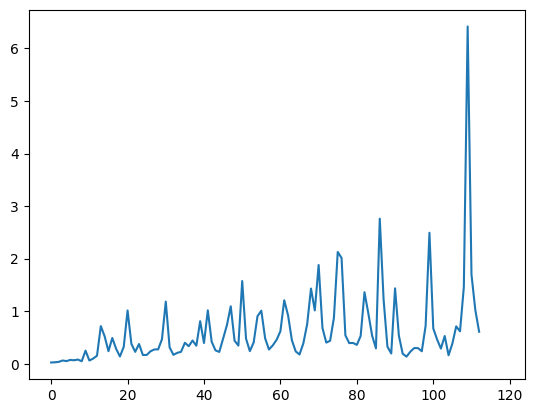

In [23]:
plt.plot(err2) # Запуск Dbscan(self_healing с шагом 10), по оси x номер точки от начала запуска, по оси y средняя MAPE для этих точек

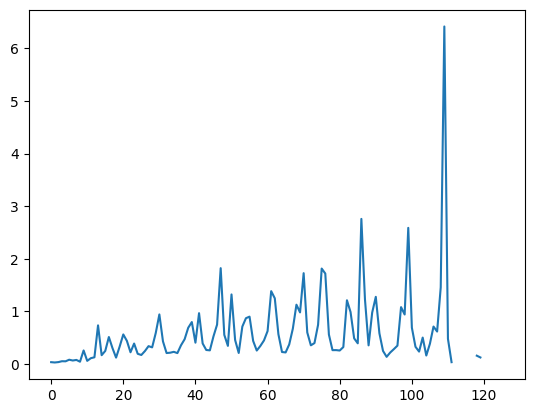

In [34]:
plt.plot(err5) # Новый запуск Dbscan(new_self_healing с шагом 10), по оси x номер точки от начала запуска, по оси y средняя MAPE для этих точек

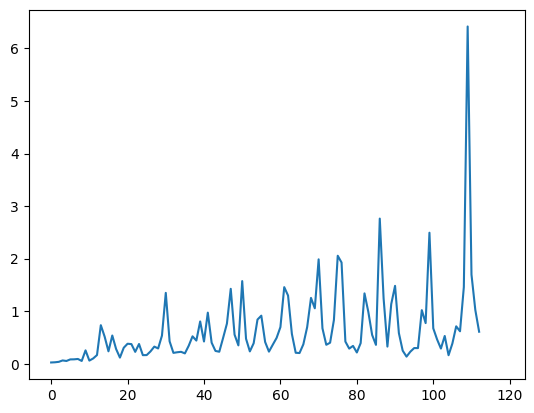

In [35]:
plt.plot(err3) # Запуск Dbscan(self_healing с шагом 15), по оси x номер точки от начала запуска, по оси y средняя MAPE для этих точек

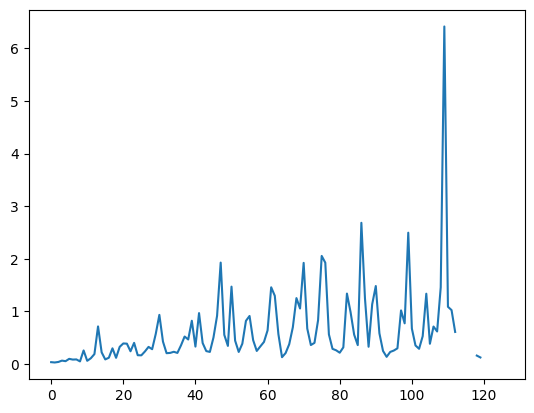

In [36]:
plt.plot(err6) # Новый запуск Dbscan(new_self_healing с шагом 15), по оси x номер точки от начала запуска, по оси y средняя MAPE для этих точек

In [37]:
print(sum(ans))
print(sum(ans2))
print(sum(ans3))
print(sum(ans4))
print(sum(ans5))
print(sum(ans6))


1893
1828
1844
1837
1878
1849


In [ ]:
ans7=[]
err7_0 = []
for u in range(10000, 15000, 100):
    print(u)
    x_test7 = x[:u].copy()
    x_test7_0 = x[:u].copy()
    for i in range(u, u + 200):
        x_test7 = np.append(x_test7, new_point(x_test7, patterns, Zs))
        x_test7_0 = np.append(x_test7_0, 0)
        if ((i - u + 1) % 5 == 0):
            self_healing_2(x_test7, x_test7_0, patterns, Zs, u)
        cnt = 0
        for j in range(i, i - 10, -1):
            if (np.isnan(x_test7[j])):
                cnt += 1
        if (cnt == 10):
            break
    cnt = 0
    for i in range(u, len(x_test7)):
        if (not np.isnan(x_test7[i])):
            cnt = i - u + 1
            if (x[i] != 0):
                while (len(err7_0) <= i - u):
                    err7_0.append([])
                err7_0[i - u].append(abs(x_test7[i] - x[i]) / x[i])
    ans7.append(cnt)
err7 = []
for i in range(len(err7_0)):
    err7.append(np.nanmean(err7_0[i]))

10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900


C:\Users\Mvideo\AppData\Local\Temp\ipykernel_12512\3854497449.py:29: RuntimeWarning: Mean of empty slice
  err7.append(np.nanmean(err7_0[i]))


In [16]:
print(sum(ans7))

1939


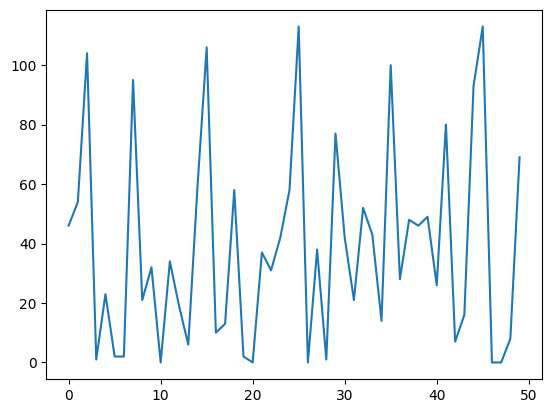

In [17]:
plt.plot(ans7) # Запуск финальной версии Dbscan(self_healing_2 с шагом 5), по оси x последняя предсказанная точка, по оси y номер запуска с шагом 100

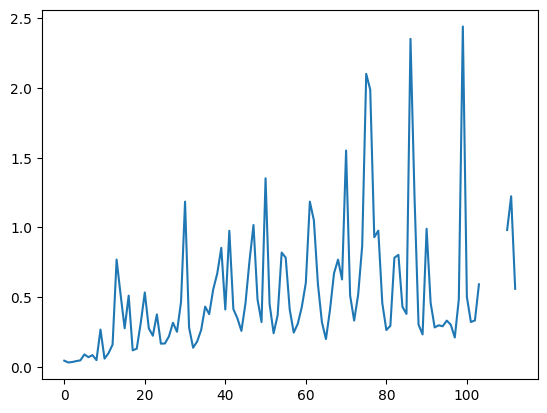

In [18]:
plt.plot(err7) # Запуск финальной версии Dbscan(self_healing_2 с шагом 5), по оси x номер точки от начала запуска, по оси y средняя MAPE для этих точек